In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.visualization import plot_histogram
from qiskit.algorithms.optimizers import COBYLA

from qiskit import *
import qiskit.quantum_info as qi
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import *
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
pi = math.pi

In [2]:
noise_model = NoiseModel()

p_err = 0.02
b_err = 0.0010
error_1q = thermal_relaxation_error(100, 100, 5) # 1 qubit thermal relaxation error
noise_model.add_all_qubit_quantum_error(error_1q, ['delay']) 

backend = AerSimulator(noise_model=noise_model)

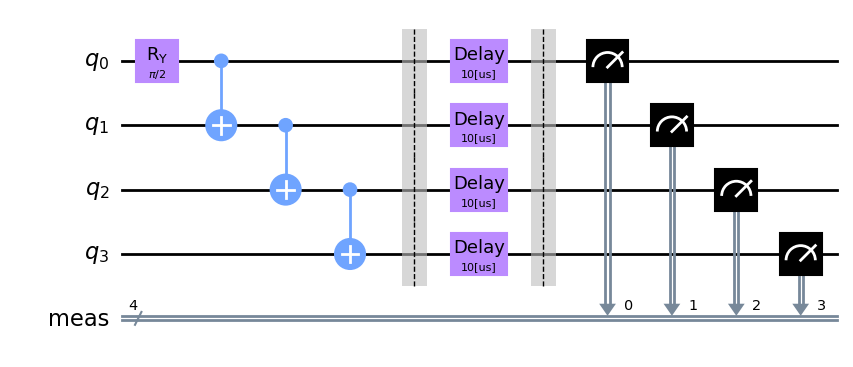

In [3]:
def U_prep(n_qubits,theta):
  qc = QuantumCircuit(n_qubits)
  qc.ry(theta,0)
  for qubit in range(n_qubits-1):
    qc.cx(qubit,qubit+1)
  qc.barrier()
  return qc

qc_without_hadamard = U_prep(4,pi/2)
qc_without_hadamard.delay(10,unit='us')
qc_without_hadamard.measure_all()
qc_without_hadamard.draw('mpl')

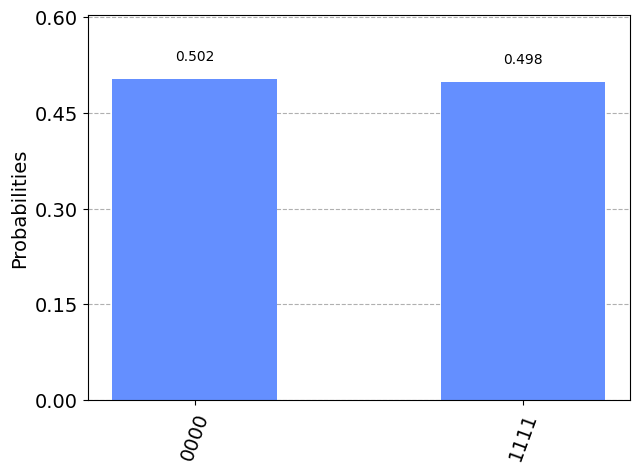

In [4]:
#Backend without Noise
results_ideal = AerSimulator().run(qc_without_hadamard,shots=10000).result()
counts_ideal = results_ideal.get_counts()
plot_histogram(counts_ideal)


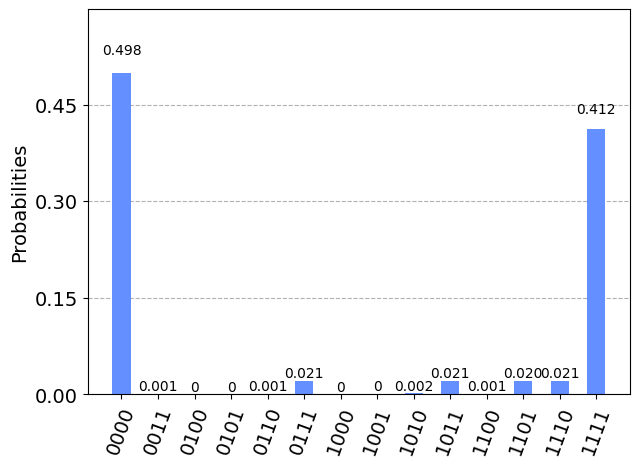

In [5]:
#Backend with noise
counts_without_hadamard = backend.run(qc_without_hadamard,shots=10000).result().get_counts()
plot_histogram(counts_without_hadamard)

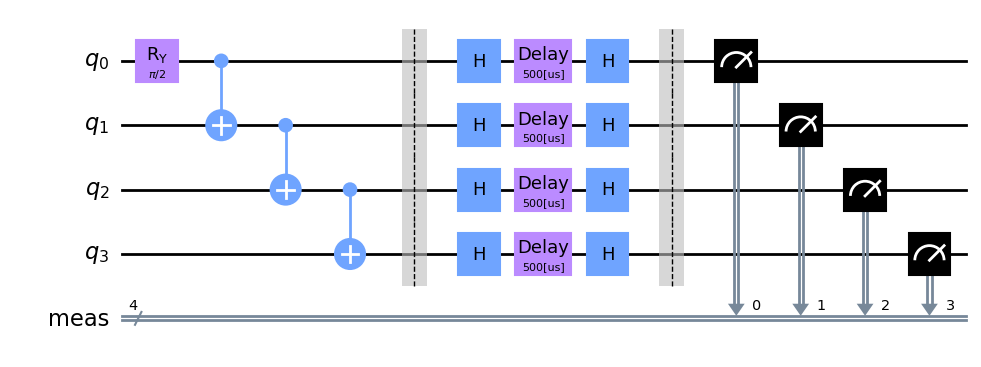

In [6]:
def padded_circuit(n_qubits,theta,delay):
  qc = U_prep(n_qubits,theta)

  for qubit in range(n_qubits):
    qc.h(qubit)
    qc.delay(delay,qubit,unit='us')
    qc.h(qubit)
  qc.measure_all()
  return qc

qc_with_hadamard = padded_circuit(4,pi/2, 500)
qc_with_hadamard.draw('mpl')


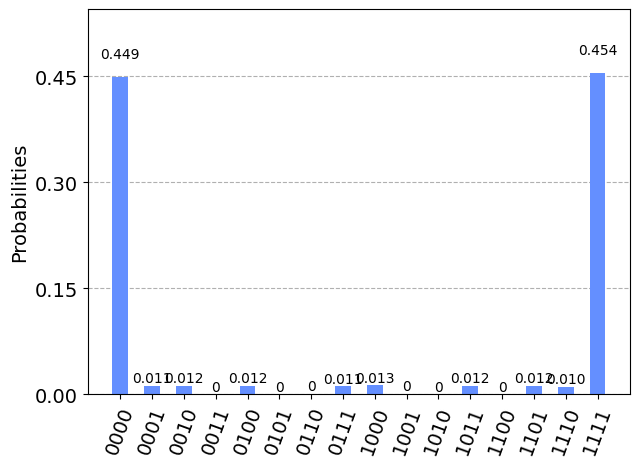

In [7]:
#Backend with Noise and padding both sides with the Hadamard gate
counts_with_hadamard = backend.run(qc_with_hadamard,shots=10000).result().get_counts()
plot_histogram(counts_with_hadamard)

In [8]:
# If state is not in the set of valid states, ouput is erroneous
def cost(counts):
  invalid_states_count = 0
  diff = 0
  counts = dict(counts)
  for state in counts.keys():
    if (state != '0000') and (state != '1111'):
      invalid_states_count += counts[state]
    # probability of getting the other 8 valid states is 5000/10000
    else:
        if (counts[state]-5000 >= 0):
            diff += abs(counts[state]-5000) # we got a valid state but how far is it from the ideal value? i.e deviation from correct value
  total_error = round((invalid_states_count + diff)/10000 , 4 )
  return {'invalid_states_count':invalid_states_count, 'deviation' : diff, 'error':total_error }


In [9]:
# counts = backend.run(qc,shots=10000).result().get_counts()
print(f"Error without noise: {cost(counts_ideal)}")
print(f"Error with noise without hadamard: {cost(counts_without_hadamard)}")
print(f"Error with noise with hadamard: {cost(counts_with_hadamard)}")

Error without noise: {'invalid_states_count': 0, 'deviation': 24, 'error': 0.0024}
Error with noise without hadamard: {'invalid_states_count': 898, 'deviation': 0, 'error': 0.0898}
Error with noise with hadamard: {'invalid_states_count': 965, 'deviation': 0, 'error': 0.0965}


In [10]:
def pad_circuits_with_gates(n_qubits,theta,delay):  
  qc = U_prep(n_qubits,theta)
  range_low, increment = 0, pi/32
  range_high = 2*pi - increment
  circuits = []
 
  angle1=range_low
  while(angle1 <= range_high):
    angle2=range_low
    while(angle2 <= range_high):
      qc_pad = qc.copy()
      for qubit in range(n_qubits):     
        qc_pad.rx(angle1,qubit)
        qc_pad.delay(delay,qubit,unit='us')
        qc_pad.rx(angle2,qubit)
            
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
          # a1.append(angle1)
          # a2.append(angle2)
      angle2 += increment
        
    angle2=range_low
    while(angle2 <= range_high):
      qc_pad = qc.copy()
      for qubit in range(n_qubits):     
        qc_pad.rx(angle1,qubit)
        qc_pad.delay(delay,qubit,unit='us')
        qc_pad.ry(angle2,qubit)
            
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
          # a1.append(angle1)
          # a2.append(angle2)
      angle2 += increment        
    angle1 += increment

  angle1=range_low
  while(angle1 <= range_high):
    angle2=range_low
    while(angle2 <= range_high):
      qc_pad = qc.copy()
      for qubit in range(n_qubits):     
        qc_pad.ry(angle1,qubit)
        qc_pad.delay(delay,qubit,unit='us')
        qc_pad.rx(angle2,qubit)
            
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
          # a1.append(angle1)
          # a2.append(angle2)
      angle2 += increment
        
    angle2=range_low
    while(angle2 <= range_high):
      qc_pad = qc.copy()
      for qubit in range(n_qubits):     
        qc_pad.ry(angle1,qubit)
        qc_pad.delay(delay,qubit,unit='us')
        qc_pad.ry(angle2,qubit)
            
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
          # a1.append(angle1)
          # a2.append(angle2)
      angle2 += increment        
    angle1 += increment
    
  return circuits

ckts = pad_circuits_with_gates(4,pi/2,10)

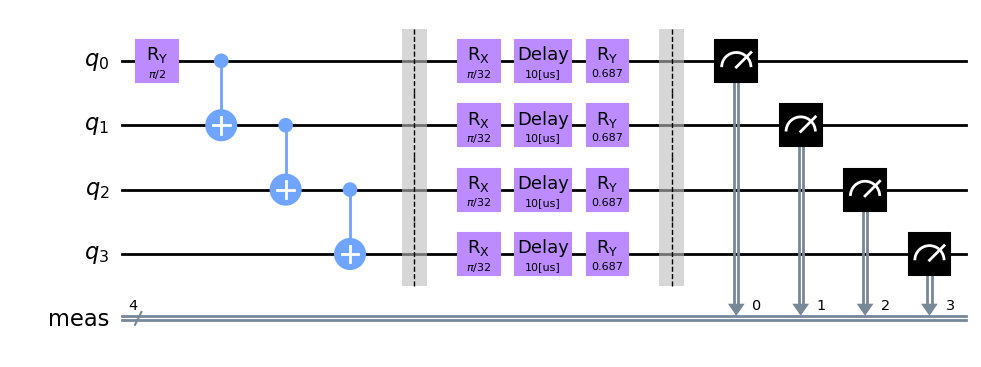

In [11]:
ckts[199][0].draw('mpl')

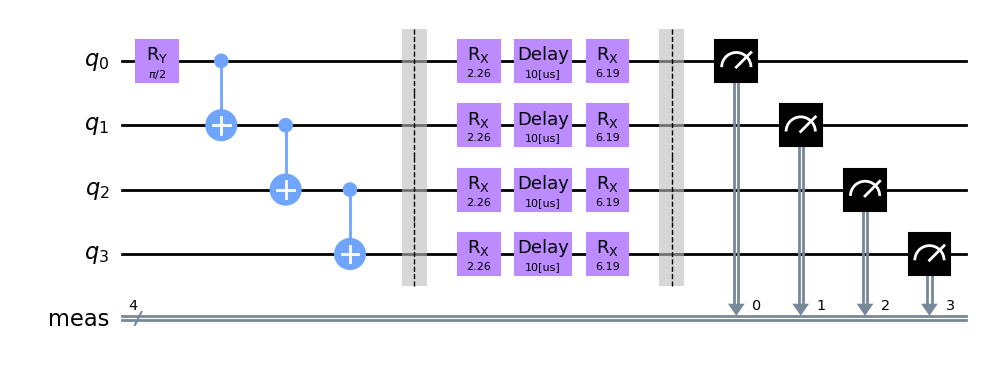

In [12]:
ckts[3007][0].draw('mpl')

In [13]:
def getError(ckt_info):
  return ckt_info['error']

In [14]:
from tqdm import tqdm
min_error = 999999
min_err_info = None
min_ckt = None
theta = []
error = []

for ckt in tqdm(range(len(ckts))):
  qc = ckts[ckt][0]
  counts = backend.run(qc,shots=10000).result().get_counts()
  err = cost(counts)
  err['index'] = ckt
  error.append(err)

error.sort(key=getError)


100%|██████████████████████████████████████████████████████████████████████████| 16384/16384 [1:30:50<00:00,  3.01it/s]
